In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import dc_params_nsi, dc_params
from PINGU.event_processing import list_of_params_nsi, return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_deltachi as deltachi_DC
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)

C:\Users\Martin\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [2]:
ndim = 3
N=13
livetime = 2.45*365*24*3600 #Effective livetime table1 DC2019
precomputed_events = True
dc_params_nsi['dm_41'] = 0.93
dc_params['dm_41'] = 0.93
emm_range = np.linspace(0,0,1)
s24_range = np.linspace(0,0,1)
emt_range = np.linspace(-1e-2,1e-2,10)
param_list = list_of_params_nsi(dc_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)



param_list = return_precomputed_nsi(1,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)

#print(param_list[1])

[0.]
[0.]
[-0.01       -0.00777778 -0.00555556 -0.00333333 -0.00111111  0.00111111  0.00333333  0.00555556  0.00777778  0.01      ]


In [3]:
H1_list = [pickle.load(open(f'./pre_computed/H1_PINGU_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_PINGU_{pid}.p','rb')) for pid in [0,1]]

H1_PINGU = np.array(H1_list)*livetime
H0_PINGU = np.array(H0_list)*livetime
H1_PINGU = np.swapaxes(H1_PINGU,0,1)

H1_list = [pickle.load(open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_DC_{pid}.p','rb')) for pid in [0,1]]

H1_DC = np.array(H1_list)*livetime
H1_DC = np.swapaxes(H1_DC,0,1)

H1_events_list = pickle.load(open(f'./pre_computed/H1_N{N}_{len(emm_range)}x{len(s24_range)}x{len(emt_range)*10}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}_nsi.p','rb'))
H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
H1_IC = np.array(H1_list_normalized)

In [4]:
sigma_a = 0.25
sigma_b = 0.04
f_PINGU = 0.15
f_DC = 2 # Not a percentage. Scales background pdf
f_IC = 0.1

PINGU_deltachi,  best_fit_index_PINGU, min_chi2_PINGU = deltachi_PINGU([H for H in H1_PINGU],H0_PINGU,emt_range,emm_range,0,[sigma_a,sigma_b],f,x0=[1,0])
DC_deltachi,  best_fit_index_DC, min_chi2_DC =deltachi_DC([H for H in H1_DC],emt_range,emm_range,0,[sigma_a,sigma_b],f,x0=[1,1,0])
IC_deltachi, best_indexIC, min_chi2_IC = deltachi_IC(H1_IC, None,np.linspace(-1e-2,1e-2,100),emm_range,0,[sigma_a,sigma_b],f,x0=[1])

In [5]:
IC_deltachi = IC_deltachi[::10]

In [6]:
global_deltachi =  DC_deltachi + IC_deltachi + PINGU_deltachi
chibar = global_deltachi - min_chi2_DC - min_chi2_IC - min_chi2_PINGU
1-chi2.cdf(chibar.min(),df=2)

0.920316186359029

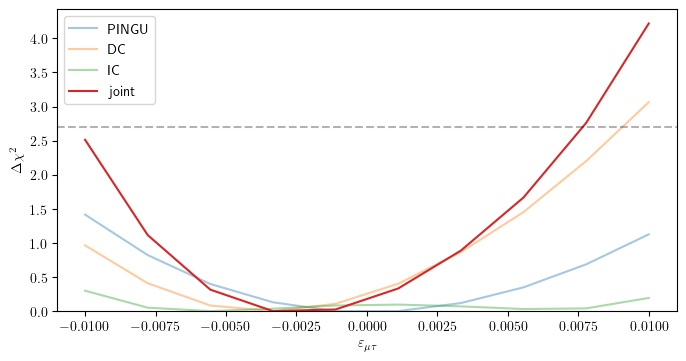

In [8]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)
demidov = (-0.023, 0.016)
plt.plot(emt_range, PINGU_deltachi - min_chi2_PINGU,label='PINGU', alpha=0.4)
plt.plot(emt_range, DC_deltachi - min_chi2_DC,label='DC', alpha=0.4)
plt.plot(emt_range, IC_deltachi - min_chi2_IC,label='IC', alpha=0.4)
plt.plot(emt_range, chibar - chibar.min(),label='joint')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
'''
plt.axvline(demidov[0], alpha=0.6,c='black', label='Demidov (DC) 2020')
plt.axvline(demidov[1], alpha=0.6,c='black')

plt.axvline(salvado[0], alpha=0.6,c='green', label='Salvado (IC) 2017')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label='DC 2017')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')
'''
#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=10)
plt.ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()